# Fairness Algorithms

This notebook consolidates the project focus areas:
- Fairness-aware Feature Selection
- Handling Conditional Discrimination:
  - Local Massaging
  - Preferential Sampling

It loads the COMPAS dataset, prepares data, applies each method, and evaluates performance and fairness metrics side-by-side.


In [39]:
# 0. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb

# Suppress pandas warnings for cleaner output
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('mode.chained_assignment', None)

sns.set_style('darkgrid')

In [40]:
# 1. Load and clean data (consolidated)
raw_path = 'data/compas-scores-two-years.csv'
df = pd.read_csv(raw_path)

# minimal cleaning consistent with existing notebooks
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'], errors='coerce')
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'], errors='coerce')

cols_drop = ['compas_screening_date','v_screening_date','decile_score.1','priors_count.1','violent_recid','type_of_assessment','v_type_of_assessment']
cols_drop = [c for c in cols_drop if c in df.columns]

data_clean = df.drop(columns=cols_drop)

# save a cleaned copy for reuse
clean_path = 'data/data_cleaned.csv'
data_clean.to_csv(clean_path, index=False)

print(data_clean.shape)
data_clean.head()

/var/folders/yd/0rx8hpn96fd0480f9ndhwn_00000gn/T/ipykernel_70381/1612007043.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['c_jail_in'] = pd.to_datetime(df['c_jail_in'], errors='coerce')
/var/folders/yd/0rx8hpn96fd0480f9ndhwn_00000gn/T/ipykernel_70381/1612007043.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['c_jail_out'] = pd.to_datetime(df['c_jail_out'], errors='coerce')


(7214, 46)


,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,score_text,screening_date,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,Male,4/18/47,69,Greater than 45,Other,0,...,Low,8/14/13,1,Low,7/7/14,7/14/14,0,327,0,0
1,3,kevon dixon,kevon,dixon,Male,1/22/82,34,25 - 45,African-American,0,...,Low,1/27/13,1,Low,1/26/13,2/5/13,9,159,1,1
2,4,ed philo,ed,philo,Male,5/14/91,24,Less than 25,African-American,0,...,Low,4/14/13,3,Low,6/16/13,6/16/13,0,63,0,1
3,5,marcu brown,marcu,brown,Male,1/21/93,23,Less than 25,African-American,0,...,High,1/13/13,6,Medium,NaN,NaN,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,Male,1/22/73,43,25 - 45,Other,0,...,Low,3/26/13,1,Low,NaN,NaN,0,1102,0,0


In [41]:
# 2. Common helpers

def partition_by_age_cat(df):
    partitions = {}
    for val in df['age_cat'].dropna().unique():
        partitions[val] = df[df['age_cat'] == val].copy()
    return partitions


def calculate_delta(partitions):
    delta_results = {
        'Less than 25': {'male': 0, 'female': 0},
        '25 - 45': {'male': 0, 'female': 0},
        'Greater than 45': {'male': 0, 'female': 0},
    }
    for age_cat, part in partitions.items():
        P_plus_male = part[part['sex'] == 'Male']['two_year_recid'].mean()
        P_plus_female = part[part['sex'] == 'Female']['two_year_recid'].mean()
        G_male = (part['sex'] == 'Male').sum()
        G_female = (part['sex'] == 'Female').sum()
        delta_results[age_cat] = {
            'male': G_male * abs((P_plus_male - P_plus_female) / 2.0),
            'female': G_female * abs((P_plus_female - P_plus_male) / 2.0),
        }
    return delta_results


X_COLUMNS = [
    'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
    'priors_count', 'days_b_screening_arrest', 'c_days_from_compas', 'c_charge_degree',
    'is_recid', 'r_days_from_arrest', 'is_violent_recid', 'score_text', 'v_decile_score',
    'v_score_text', 'start', 'end', 'event'
]
Y_COLUMN = 'two_year_recid'

## Fairness-aware Feature Selection

Approach: compute mutual information between features and target, and penalize features highly associated with the sensitive attribute(s) to reduce discriminatory influence. We’ll demonstrate a simple MI-based selector you can swap with more advanced methods.


In [42]:
from sklearn.feature_selection import mutual_info_classif

# Prepare encodings for MI
work = data_clean.copy()

# Keep minimal columns needed; drop columns entirely missing in some variants
work = work.dropna(subset=['two_year_recid'])

# One-hot encode categoricals for MI
categorical_cols = [c for c in ['race','sex','age_cat','c_charge_degree','score_text','v_score_text'] if c in work.columns]
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = enc.fit_transform(work[categorical_cols]) if categorical_cols else np.empty((len(work),0))
enc_feature_names = enc.get_feature_names_out(categorical_cols) if categorical_cols else []

numeric_cols = [c for c in ['juv_fel_count','decile_score','juv_misd_count','juv_other_count','priors_count','days_b_screening_arrest','c_days_from_compas','r_days_from_arrest','is_recid','is_violent_recid','start','end','event'] if c in work.columns]
X_num = work[numeric_cols].fillna(0).to_numpy() if numeric_cols else np.empty((len(work),0))

X_mi = np.hstack([encoded, X_num])
y_mi = work['two_year_recid'].astype(int).to_numpy()

mi = mutual_info_classif(X_mi, y_mi, discrete_features=[True]*len(enc_feature_names)+[False]*len(numeric_cols), random_state=42)

# Penalize features highly correlated with sensitive attr `sex` (demo: remove strong sex-related one-hots)
penalize_mask = np.array([('sex_' in n) for n in enc_feature_names] + [False]*len(numeric_cols)) if len(enc_feature_names) else np.zeros(len(mi), dtype=bool)

mi_penalized = mi.copy()
mi_penalized[penalize_mask] *= 0.1

# Select top-k features post-penalty
k = min(20, mi_penalized.shape[0])
selected_idx = np.argsort(mi_penalized)[-k:]

selected_names = [list(enc_feature_names)+numeric_cols][0]
selected_feature_names = [selected_names[i] for i in selected_idx]

print('Selected features:', selected_feature_names)

Selected features: ['c_days_from_compas', 'juv_other_count', 'race_African-American', 'v_score_text_Medium', 'start', 'juv_misd_count', 'age_cat_Greater than 45', 'juv_fel_count', 'days_b_screening_arrest', 'v_score_text_High', 'v_score_text_Low', 'score_text_High', 'score_text_Low', 'priors_count', 'r_days_from_arrest', 'decile_score', 'is_violent_recid', 'event', 'end', 'is_recid']


## Local Massaging (age-stratified)
Based on deltas computed within each age category, adjust labels of borderline cases to reduce sex-based disparity.


In [43]:
def apply_local_massaging(df, age_group, delta_results, xgb_params, feature_cols, y_col, num_boost_round=100):
    age_df = df[df['age_cat'] == age_group].copy()
    # Restrict to selected features when available; keep sex for grouping
    cols_present = [c for c in feature_cols if c in age_df.columns]
    keep_cols = cols_present + ['sex', y_col]
    age_df = age_df[keep_cols].copy()

    # Cast categoricals for xgb
    for col in cols_present:
        if age_df[col].dtype == 'object':
            age_df[col] = age_df[col].astype('category')

    X = age_df[cols_present]
    y = age_df[y_col].astype(int).values

    dtrain = xgb.DMatrix(X, label=y, enable_categorical=True, feature_names=cols_present)
    bst = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round)

    age_df['two_year_recid_prob'] = bst.predict(dtrain)

    d_male = int(round(delta_results[age_group]['male']))
    d_female = int(round(delta_results[age_group]['female']))

    # Females: increase some 0->1 near boundary
    idx_f = age_df[(age_df['sex'] == 'Female') & (age_df[y_col] == 0)].nlargest(d_female, 'two_year_recid_prob').index
    age_df.loc[idx_f, y_col] = 1

    # Males: decrease some 1->0 near boundary
    idx_m = age_df[(age_df['sex'] == 'Male') & (age_df[y_col] == 1)].nsmallest(d_male, 'two_year_recid_prob').index
    age_df.loc[idx_m, y_col] = 0

    return age_df

In [44]:
from pathlib import Path

# Compute partitions and deltas
parts = partition_by_age_cat(data_clean)
deltas = calculate_delta(parts)

out_dir = Path("output/age/local_massaging")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "lm_full.csv"

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

feature_cols_for_algos = selected_feature_names if len(selected_feature_names) else X_COLUMNS

lm_results = []
for group in parts.keys():
    res = apply_local_massaging(data_clean, group, deltas, xgb_params, feature_cols_for_algos, Y_COLUMN)
    res['age_cat'] = group
    lm_results.append(res)

lm_full = pd.concat(lm_results, ignore_index=True)
lm_path = 'output/age/local_massaging'
lm_full.to_csv(csv_path, index=False)
print('Saved:', lm_path, lm_full.shape)

Saved: output/age/local_massaging (7214, 17)


## Preferential Sampling (age-stratified)
Delete/duplicate near-boundary cases to rebalance outcomes across sex within age strata.


In [45]:
def apply_preferential_sampling(df, xgb_params, delta_male, delta_female, feature_cols, y_col, num_boost_round=100):
    work = df.copy()
    cols_present = [c for c in feature_cols if c in work.columns]
    keep_cols = cols_present + ['sex', y_col]
    work = work[keep_cols].copy()

    for col in cols_present:
        if work[col].dtype == 'object':
            work[col] = work[col].astype('category')

    X = work[cols_present]
    y = work[y_col].astype(int).values

    dtrain = xgb.DMatrix(X, label=y, enable_categorical=True, feature_names=cols_present)
    bst = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round)

    work['two_year_recid_prob'] = bst.predict(dtrain)

    dm = max(0, int(delta_male) // 2)
    dfm = max(0, int(delta_female) // 2)

    # Male deletions (1) and duplications (0)
    idx_del_m = work[(work['sex'] == 'Male') & (work[y_col] == 1)].nsmallest(dm, 'two_year_recid_prob').index
    work = work.drop(index=idx_del_m)

    idx_dup_m = work[(work['sex'] == 'Male') & (work[y_col] == 0)].nlargest(dm, 'two_year_recid_prob').index
    work = pd.concat([work, work.loc[idx_dup_m]], ignore_index=True)

    # Female deletions (0) and duplications (1)
    idx_del_f = work[(work['sex'] == 'Female') & (work[y_col] == 0)].nlargest(dfm, 'two_year_recid_prob').index
    work = work.drop(index=idx_del_f)

    idx_dup_f = work[(work['sex'] == 'Female') & (work[y_col] == 1)].nsmallest(dfm, 'two_year_recid_prob').index
    work = pd.concat([work, work.loc[idx_dup_f]], ignore_index=True)

    work.reset_index(drop=True, inplace=True)
    return work


In [46]:
ps_results = []
for group, part in parts.items():
    dm = deltas[group]['male']
    dfm = deltas[group]['female']
    res = apply_preferential_sampling(part, xgb_params, dm, dfm, feature_cols_for_algos, Y_COLUMN)
    res['age_cat'] = group
    ps_results.append(res)

ps_full = pd.concat(ps_results, ignore_index=True)
out_dir = Path("output/age/preferential_sample")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "full_results_Preferential_Sampling.csv"
ps_full.to_csv(csv_path, index=False)
print("Saved:", str(csv_path), ps_full.shape)


Saved: output/age/preferential_sample/full_results_Preferential_Sampling.csv (7214, 17)


## Unified Evaluation
Compute accuracy, F1, demographic parity gap, and equal opportunity gap for both methods.


In [47]:
def evaluate_binary(df):
    preds = (df['two_year_recid_prob'] >= 0.5).astype(int)
    actuals = df[Y_COLUMN].astype(int)
    acc = accuracy_score(actuals, preds)
    f1 = f1_score(actuals, preds)

    # demographic parity
    male_pos = (df[df['sex']=='Male']['two_year_recid_prob'] >= 0.5).mean()
    female_pos = (df[df['sex']=='Female']['two_year_recid_prob'] >= 0.5).mean()
    dp_gap = abs(male_pos - female_pos)

    # equal opportunity (TPR gap)
    male_pos_actual = df[(df['sex']=='Male') & (df[Y_COLUMN]==1)]
    female_pos_actual = df[(df['sex']=='Female') & (df[Y_COLUMN]==1)]
    male_eo = (male_pos_actual['two_year_recid_prob'] >= 0.5).mean() if len(male_pos_actual)>0 else np.nan
    female_eo = (female_pos_actual['two_year_recid_prob'] >= 0.5).mean() if len(female_pos_actual)>0 else np.nan
    eo_gap = abs(male_eo - female_eo) if (not np.isnan(male_eo) and not np.isnan(female_eo)) else np.nan

    return {
        'accuracy': acc,
        'f1': f1,
        'dp_gap': dp_gap,
        'eo_gap': eo_gap,
        'male_pos_rate': male_pos,
        'female_pos_rate': female_pos,
        'male_eo': male_eo,
        'female_eo': female_eo,
    }

lm_metrics = evaluate_binary(lm_full)
ps_metrics = evaluate_binary(ps_full)

# Consolidated summary: Baseline (race), Local Massaging (sex, age-stratified), Preferential Sampling (sex, age-stratified)

def dp_eo_from_preds(preds, actuals, sens_series):
    preds = preds.astype(int)
    actuals = actuals.astype(int)
    sens = sens_series.astype(int)
    rate0 = preds[sens==0].mean()
    rate1 = preds[sens!=0].mean()
    dp_gap = abs(rate0 - rate1)
    idx0 = (sens==0) & (actuals==1)
    idx1 = (sens!=0) & (actuals==1)
    tpr0 = preds[idx0].mean() if idx0.any() else float('nan')
    tpr1 = preds[idx1].mean() if idx1.any() else float('nan')
    eo_gap = abs(tpr0 - tpr1) if not (np.isnan(tpr0) or np.isnan(tpr1)) else float('nan')
    return dp_gap, eo_gap

# Reuse baseline artifacts from earlier cell if present; otherwise compute quickly here
try:
    _ = y_te_hat
    _ = s_te
    base_dp_gap, base_eo_gap = dp_eo_from_preds(y_te_hat, y_te.flatten(), s_te)
except NameError:
    X_base_tmp, y_base_tmp = preprocess_data(data_clean)
    X_tr_tmp, X_te_tmp, y_tr_tmp, y_te_tmp, s_tr_tmp, s_te_tmp = prepare_train_test_sets(X_base_tmp, y_base_tmp)
    scaler_tmp = StandardScaler(); X_tr_tmp = scaler_tmp.fit_transform(X_tr_tmp); X_te_tmp = scaler_tmp.transform(X_te_tmp)
    lr_tmp = LogisticRegression(fit_intercept=False, max_iter=5000, solver='liblinear').fit(X_tr_tmp, y_tr_tmp.flatten())
    y_te_hat_tmp = lr_tmp.predict(X_te_tmp)
    base_dp_gap, base_eo_gap = dp_eo_from_preds(y_te_hat_tmp, y_te_tmp.flatten(), s_te_tmp)

summary = pd.DataFrame([
    {'method':'Baseline (race)', 'accuracy': np.nan, 'f1': np.nan, 'dp_gap': base_dp_gap, 'eo_gap': base_eo_gap},
    {'method':'Local Massaging (sex|age-stratified)', **lm_metrics},
    {'method':'Preferential Sampling (sex|age-stratified)', **ps_metrics}
])
summary


,method,accuracy,f1,dp_gap,eo_gap,male_pos_rate,female_pos_rate,male_eo,female_eo
0,Baseline (race),NaN,NaN,0.167816,0.000000,NaN,NaN,NaN,NaN
1,Local Massaging (sex|age-stratified),0.940116,0.931034,0.115281,0.131261,0.475855,0.360573,1.0,0.868739
2,Preferential Sampling (sex|age-stratified),0.995010,0.994266,0.065303,0.000000,0.450249,0.384946,1.0,1.000000


In [48]:
# Additional imports for baselines and models (already imported in cell 1)
from xgboost import XGBClassifier

## Baselines and Calibration (race-focused)
Replicates baseline preprocessing and models to benchmark accuracy and group calibration differences.


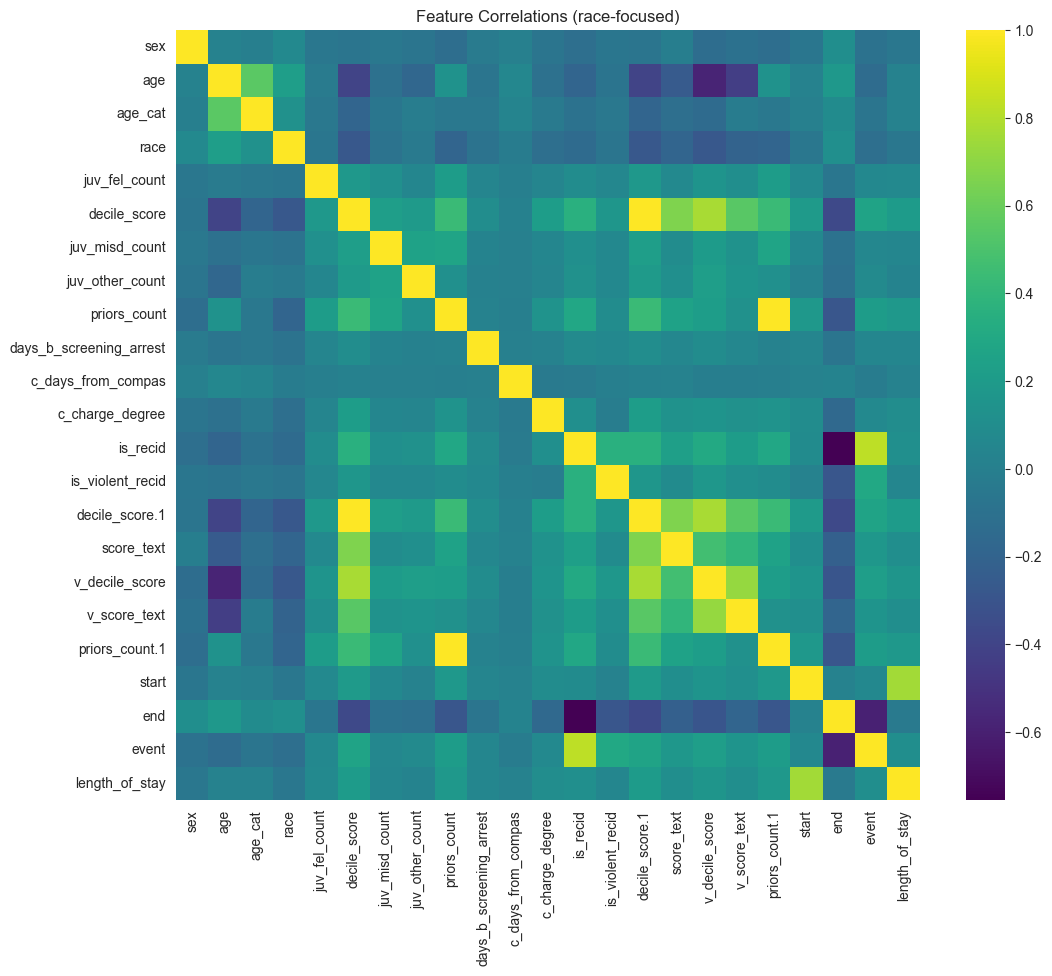

Baseline LogisticRegression - train acc: 0.9705802233723781
Baseline LogisticRegression - test acc: 0.9694989106753813
Calibration diff (train/test): -0.011542209545503668 -0.023695652173913118
Baseline dp_gap (race): 0.16781620553359683 Baseline eo_gap (race): 0.0


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RF acc: 0.9912854030501089
RF confusion:
 [[479   8]
 [  0 431]]
XGB acc: 0.9891067538126361
XGB confusion:
 [[480   7]
 [  3 428]]
[LightGBM] [Info] Number of positive: 1737, number of negative: 1934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 3671, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473168 -> initscore=-0.107431
[LightGBM] [Info] Start training from score -0.107431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:38:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [49]:
# Preprocess (race-focused baseline)
def preprocess_data(df):
    data = df[(df['race']=='African-American') | (df['race']=='Caucasian')].copy()
    # Use .dt.days to avoid timedelta resolution errors
    data["length_of_stay"] = (pd.to_datetime(data.c_jail_out) - pd.to_datetime(data.c_jail_in)).dt.days
    data = data[(data.days_b_screening_arrest <= 30) & (data.days_b_screening_arrest >= -30)]
    data = data[data.is_recid != -1]
    data = data[data.c_charge_degree != "O"]
    data = data[data.score_text != "N/A"]
    drop_cols = ['first','last','c_case_number','c_charge_desc','violent_recid','vr_charge_degree','vr_case_number','vr_offense_date','vr_charge_desc',
                 'c_arrest_date','r_jail_out','r_jail_in','r_days_from_arrest','r_charge_desc','r_offense_date','r_case_number','r_charge_degree']
    data = data.drop(columns=[c for c in drop_cols if c in data.columns])
    data['c_days_from_compas'] = data['c_days_from_compas'].fillna(data['c_days_from_compas'].mode()[0])
    data = data.dropna()
    X = data.drop(columns=[c for c in ['id','two_year_recid','dob','name','v_type_of_assessment','type_of_assessment'] if c in data.columns])
    X.set_index(data.id, inplace=True)
    y = data[['two_year_recid']].copy()
    y.set_index(data.id, inplace=True)
    X = X.drop(columns=[c for c in ['c_offense_date','c_jail_in','c_jail_out','out_custody','in_custody','screening_date','compas_screening_date','v_screening_date'] if c in X.columns], errors='ignore')
    # Use map instead of replace to avoid FutureWarnings
    race_mapping = {'African-American': 0, 'Caucasian': 1.0}
    X['race'] = X['race'].map(race_mapping)
    
    sex_mapping = {'Male': 0, 'Female': 1.0}
    X['sex'] = X['sex'].map(sex_mapping)
    
    age_mapping = {'25 - 45': 0, 'Less than 25': 1.0, 'Greater than 45': 2.0}
    X['age_cat'] = X['age_cat'].map(age_mapping)
    
    if 'c_charge_degree' in X.columns:
        charge_mapping = {'M': 0, 'F': 1.0}
        X['c_charge_degree'] = X['c_charge_degree'].map(charge_mapping)
    
    score_mapping = {'Low': 0, 'High': 1.0, 'Medium': 2.0}
    X['score_text'] = X['score_text'].map(score_mapping)
    
    if 'v_score_text' in X.columns:
        X['v_score_text'] = X['v_score_text'].map(score_mapping)
    X = X.fillna(0)
    return X, np.array(y)

def prepare_train_test_sets(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    x_sensitive_tr = X_train.loc[:, 'race']
    x_sensitive_te = X_test.loc[:, 'race']
    X_train = X_train.drop(columns=['race'])
    X_test = X_test.drop(columns=['race'])
    for d in (X_train, X_test, x_sensitive_tr, x_sensitive_te):
        d.reset_index(drop=True, inplace=True)
    return X_train, X_test, y_train, y_test, x_sensitive_tr, x_sensitive_te

def calculate_calibration_difference(predictions, actual_labels, sensitive_attributes):
    correct_0 = sum((s==0) and (p==a) for p,a,s in zip(predictions, actual_labels, sensitive_attributes))
    correct_1 = sum((s!=0) and (p==a) for p,a,s in zip(predictions, actual_labels, sensitive_attributes))
    total_0 = max(sum(s==0 for s in sensitive_attributes), 1)
    total_1 = max(sum(s!=0 for s in sensitive_attributes), 1)
    return (correct_0/total_0) - (correct_1/total_1)

# Build baselines
X_base, y_base = preprocess_data(df)
corr = X_base.corr()
plt.figure(figsize=(12,10)); sns.heatmap(corr, annot=False, cmap='viridis'); plt.title('Feature Correlations (race-focused)'); plt.show()

X_tr, X_te, y_tr, y_te, s_tr, s_te = prepare_train_test_sets(X_base, y_base)

# Scale the data for better convergence
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_te_scaled = scaler.transform(X_te)

logreg = LogisticRegression(fit_intercept=False, max_iter=5000, solver='liblinear').fit(X_tr_scaled, y_tr.flatten())
y_tr_hat = logreg.predict(X_tr_scaled); y_te_hat = logreg.predict(X_te_scaled)
print('Baseline LogisticRegression - train acc:', logreg.score(X_tr_scaled, y_tr.flatten()))
print('Baseline LogisticRegression - test acc:', logreg.score(X_te_scaled, y_te.flatten()))

# Baseline fairness (race): demographic parity and equal opportunity gaps
def dp_eo_from_preds(preds, actuals, sens_series):
    preds = preds.astype(int)
    actuals = actuals.astype(int)
    sens = sens_series.astype(int)
    rate0 = preds[sens==0].mean()
    rate1 = preds[sens!=0].mean()
    dp_gap = abs(rate0 - rate1)
    idx0 = (sens==0) & (actuals==1)
    idx1 = (sens!=0) & (actuals==1)
    tpr0 = preds[idx0].mean() if idx0.any() else float('nan')
    tpr1 = preds[idx1].mean() if idx1.any() else float('nan')
    eo_gap = abs(tpr0 - tpr1) if not (np.isnan(tpr0) or np.isnan(tpr1)) else float('nan')
    return dp_gap, eo_gap

base_calib_train = calculate_calibration_difference(y_tr_hat, y_tr.flatten(), s_tr.values)
base_calib_test = calculate_calibration_difference(y_te_hat, y_te.flatten(), s_te.values)
print('Calibration diff (train/test):', base_calib_train, base_calib_test)
base_dp_gap, base_eo_gap = dp_eo_from_preds(y_te_hat, y_te.flatten(), s_te)
print('Baseline dp_gap (race):', base_dp_gap, 'Baseline eo_gap (race):', base_eo_gap)

rf = RandomForestClassifier(random_state=42).fit(X_tr_scaled, y_tr)
y_rf = rf.predict(X_te_scaled)
print('RF acc:', accuracy_score(y_te, y_rf)); print('RF confusion:\n', confusion_matrix(y_te, y_rf))

xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_tr_scaled, y_tr)
y_xgb = xgb_clf.predict(X_te_scaled)
print('XGB acc:', accuracy_score(y_te, y_xgb)); print('XGB confusion:\n', confusion_matrix(y_te, y_xgb))

if lgb is not None:
    gbm = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.01, n_estimators=50,
                             subsample=0.5, colsample_bytree=0.5, reg_alpha=0.5, reg_lambda=0.5, random_state=42)
    gbm.fit(X_tr_scaled, y_tr)
    y_lgb = gbm.predict(X_te_scaled)
    print('LGBM acc:', accuracy_score(y_te, y_lgb)); print('LGBM confusion:\n', confusion_matrix(y_te, y_lgb))


## Race-based Local Massaging
Implements the local massaging approach operating on race groups (African-American vs Caucasian).


In [50]:
from sklearn.preprocessing import OneHotEncoder

def partition_data(X, sensitive_attributes):
    partitions = []
    for attr, value in sensitive_attributes.items():
        X_copy = X.copy()
        X_copy[attr] = value
        partitions.append(X_copy)
    return partitions


def adjust_predictions(data_item, y_pred, y_probabilities, fairness_threshold=12):
    data_copy = data_item.copy()
    data_copy['label'] = y_pred
    african_americans = data_copy[data_copy['race'] == 'African-American']
    caucasians = data_copy[data_copy['race'] == 'Caucasian']
    african_american_rate = round((african_americans['label'] == 1).mean(), 2)
    caucasian_rate = round((caucasians['label'] == 1).mean(), 2)
    p_star = (african_american_rate + caucasian_rate) / 2
    threshold = np.abs(african_american_rate - p_star)

    probabilities_df = pd.DataFrame(y_probabilities, columns=['No', 'Yes'])
    probabilities_df.set_index(data_item.index, inplace=True)
    probabilities_df['race'] = data_item['race']
    probabilities_df['label'] = y_pred
    temp = probabilities_df[(np.abs(probabilities_df['Yes'] - probabilities_df['No']) <= fairness_threshold * threshold)]

    # Fix chained assignment warnings by using .loc properly
    for idx in temp.index:
        if temp.loc[idx, 'race'] == 'African-American' and temp.loc[idx, 'Yes'] > temp.loc[idx, 'No']:
            temp.loc[idx, 'label'] = 0
        elif temp.loc[idx, 'race'] == 'Caucasian' and temp.loc[idx, 'Yes'] < temp.loc[idx, 'No']:
            temp.loc[idx, 'label'] = 1

    data_copy.loc[temp.index, 'label'] = temp['label']
    return data_copy


def local_massaging(X, sensitive_attribute_value, sensitive_attributes, y):
    X = X.copy()
    X['race'] = sensitive_attribute_value
    data_partitions = partition_data(X, sensitive_attributes)
    adjusted_data = []
    for item in data_partitions:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoded_data = encoder.fit_transform(item)
        X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, test_size=.2, random_state=5)
        forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)
        y_pred = forest.predict(encoded_data)
        y_prob = forest.predict_proba(encoded_data)
        temp_df = adjust_predictions(item, y_pred, y_prob)
        adjusted_data.append(temp_df[['label']])

    result = pd.concat(adjusted_data, axis=1)
    result.loc[result.sum(axis=1) <= 2, 'new_label'] = 0
    result.loc[result.sum(axis=1) >= 3, 'new_label'] = 1
    X['new_label'] = result['new_label']
    return X

# Run race-based local massaging
# Prepare inputs similar to original notebook
raw_X = df.copy()
X_cols = [
 'compas_screening_date','age','age_cat','juv_fel_count','decile_score','juv_misd_count','juv_other_count','priors_count',
 'days_b_screening_arrest','c_jail_in','c_jail_out','c_offense_date','c_days_from_compas','c_charge_degree','is_recid','is_violent_recid',
 'type_of_assessment','decile_score.1','screening_date','v_type_of_assessment','v_decile_score','v_screening_date','in_custody','out_custody',
 'priors_count.1','start','end','event']
E_LIST = ['first', 'last', 'c_charge_desc', 'score_text' , 'v_score_text']
X_subset = raw_X[[c for c in X_cols if c in raw_X.columns]]
X_subset = X_subset.copy()
X_subset['race'] = raw_X['race']
y_target = raw_X['two_year_recid'].values

lm_race = local_massaging(X_subset, raw_X[['race']], raw_X[E_LIST], y_target)
af = lm_race[lm_race.race=='African-American']; ca = lm_race[lm_race.race=='Caucasian']
rate_af = round((af['new_label']==1).mean(),2); rate_ca = round((ca['new_label']==1).mean(),2)
print('Race-based LM positive rates (AA, CA):', rate_af, rate_ca)


Race-based LM positive rates (AA, CA): 0.49 0.43


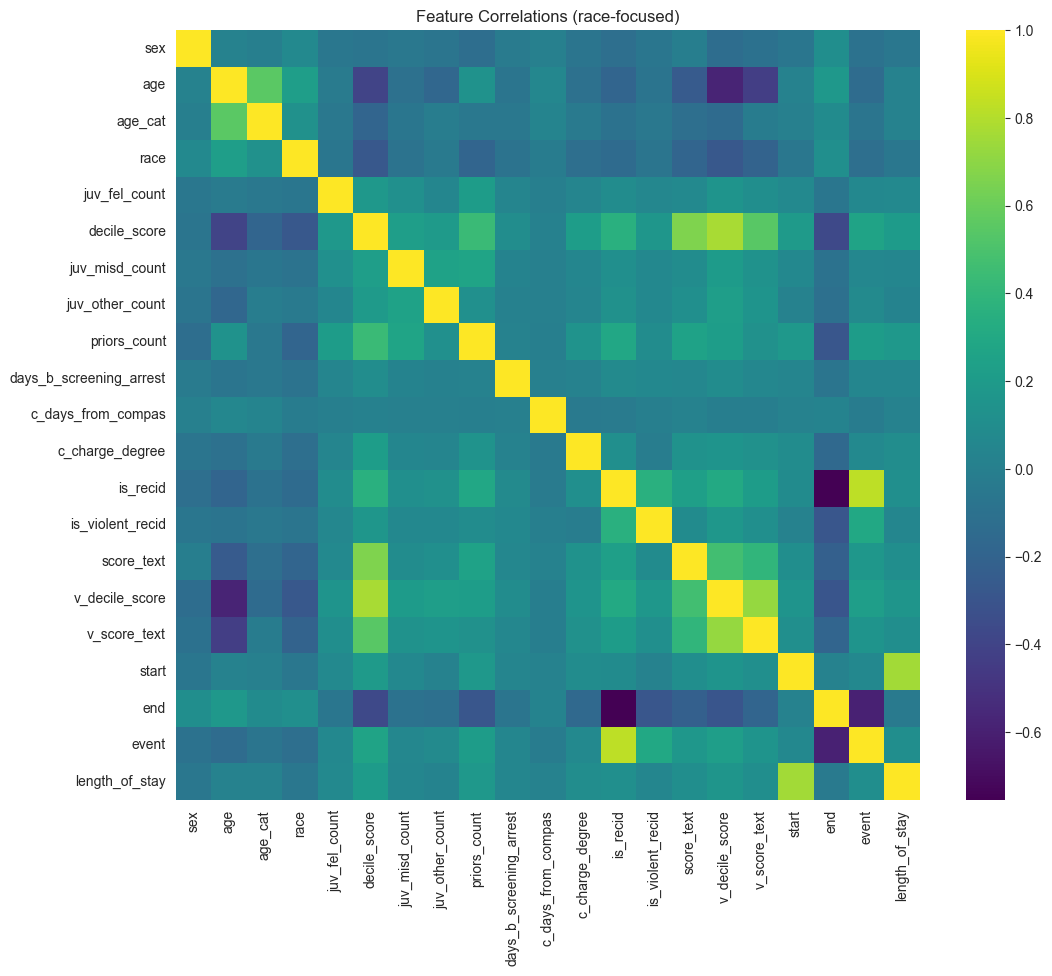

Baseline LogisticRegression - train acc: 0.9705802233723781
Baseline LogisticRegression - test acc: 0.9694989106753813
Calibration diff (train/test): -0.011542209545503668 -0.023695652173913118


/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:38:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RF acc: 0.9901960784313726
RF confusion:\n [[479   8]
 [  1 430]]
XGB acc: 0.9891067538126361
XGB confusion:\n [[480   7]
 [  3 428]]
[LightGBM] [Info] Number of positive: 1737, number of negative: 1934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 3671, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473168 -> initscore=-0.107431
[LightGBM] [Info] Start training from score -0.107431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [51]:
# Fix baseline preprocessing - use data_clean instead of df
X_base, y_base = preprocess_data(data_clean)
corr = X_base.corr()
plt.figure(figsize=(12,10)); sns.heatmap(corr, annot=False, cmap='viridis'); plt.title('Feature Correlations (race-focused)'); plt.show()

X_tr, X_te, y_tr, y_te, s_tr, s_te = prepare_train_test_sets(X_base, y_base)

# Scale the data for better convergence
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_te_scaled = scaler.transform(X_te)

logreg = LogisticRegression(fit_intercept=False, max_iter=5000, solver='liblinear').fit(X_tr_scaled, y_tr.flatten())
y_tr_hat = logreg.predict(X_tr_scaled); y_te_hat = logreg.predict(X_te_scaled)
print('Baseline LogisticRegression - train acc:', logreg.score(X_tr_scaled, y_tr.flatten()))
print('Baseline LogisticRegression - test acc:', logreg.score(X_te_scaled, y_te.flatten()))
base_calib_train = calculate_calibration_difference(y_tr_hat, y_tr.flatten(), s_tr.values)
base_calib_test = calculate_calibration_difference(y_te_hat, y_te.flatten(), s_te.values)
print('Calibration diff (train/test):', base_calib_train, base_calib_test)

rf = RandomForestClassifier(random_state=42).fit(X_tr_scaled, y_tr)
y_rf = rf.predict(X_te_scaled)
print('RF acc:', accuracy_score(y_te, y_rf)); print('RF confusion:\\n', confusion_matrix(y_te, y_rf))

xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_tr_scaled, y_tr)
y_xgb = xgb_clf.predict(X_te_scaled)
print('XGB acc:', accuracy_score(y_te, y_xgb)); print('XGB confusion:\\n', confusion_matrix(y_te, y_xgb))

if lgb is not None:
    gbm = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.01, n_estimators=50,
                             subsample=0.5, colsample_bytree=0.5, reg_alpha=0.5, reg_lambda=0.5, random_state=42)
    gbm.fit(X_tr_scaled, y_tr)
    y_lgb = gbm.predict(X_te_scaled)
    print('LGBM acc:', accuracy_score(y_te, y_lgb)); print('LGBM confusion:\\n', confusion_matrix(y_te, y_lgb))


In [52]:
def ceildiv(a, b):
    return -(a // -b)


def adjust_labels(item_data, predicted_labels, predicted_probabilities, fairness_threshold=6):
    data_copy = item_data.copy()
    data_copy['predicted_label'] = predicted_labels
    african_american_data = data_copy[data_copy.race == 'African-American']
    caucasian_data = data_copy[data_copy.race == 'Caucasian']
    rate_af = round((african_american_data['predicted_label'] == 1).mean(), 2)
    rate_ca = round((caucasian_data['predicted_label'] == 1).mean(), 2)
    p_star = (rate_af + rate_ca) / 2
    threshold = np.abs(rate_af - p_star)

    test_df = pd.DataFrame(predicted_probabilities, columns=['No', 'Yes'])
    test_df.set_index(item_data.index, inplace=True)
    test_df['race'] = item_data['race']
    test_df['predicted_label'] = predicted_labels
    filtered_data = test_df[(np.abs(test_df.Yes - test_df.No) <= fairness_threshold * threshold)]
    filtered_counts = filtered_data[['race', 'predicted_label']].value_counts().to_dict()

    aa_0 = ceildiv(filtered_counts.get(('African-American', 0), 0), 2)
    aa_1 = ceildiv(filtered_counts.get(('African-American', 1), 0), 2)
    ca_0 = ceildiv(filtered_counts.get(('Caucasian', 0), 0), 2)
    ca_1 = ceildiv(filtered_counts.get(('Caucasian', 1), 0), 2)

    aa_replace = min(aa_0, aa_1)
    ca_replace = min(ca_0, ca_1)

    count_aa = 0
    count_ca = 0

    # Fix chained assignment by using proper indexing
    for idx in list(filtered_data.index):
        if count_aa < aa_replace and filtered_data.loc[idx, 'race'] == 'African-American' and filtered_data.loc[idx, 'predicted_label'] == 1:
            filtered_data = filtered_data.copy()  # Ensure we're working with a copy
            filtered_data.loc[idx, 'predicted_label'] = 0
            count_aa += 1
        if count_ca < ca_replace and filtered_data.loc[idx, 'race'] == 'Caucasian' and filtered_data.loc[idx, 'predicted_label'] == 0:
            filtered_data = filtered_data.copy()  # Ensure we're working with a copy
            filtered_data.loc[idx, 'predicted_label'] = 1
            count_ca += 1
        if count_aa >= aa_replace and count_ca >= ca_replace:
            break

    data_copy.loc[filtered_data.index, 'predicted_label'] = filtered_data['predicted_label']
    return data_copy


def local_preferential_sampling(input_features, race_info, partition_size, target_labels):
    input_features = input_features.copy()
    input_features['race'] = race_info
    partitioned_data_list = partition_data(input_features, partition_size)
    dataframe_list = []
    for data_partition in partitioned_data_list:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoded_data = encoder.fit_transform(data_partition)
        X_train, X_test, y_train, y_test = train_test_split(encoded_data, target_labels, test_size=.3, random_state=42)
        forest_classifier = RandomForestClassifier(random_state=88).fit(X_train, y_train)
        predicted_labels = forest_classifier.predict(encoded_data)
        predicted_probabilities = forest_classifier.predict_proba(encoded_data)
        adjusted_data = adjust_labels(data_partition, predicted_labels, predicted_probabilities, 6)
        dataframe_list.append(adjusted_data[['predicted_label']])

    result_dataframe = pd.concat(dataframe_list, axis=1)
    result_dataframe.loc[result_dataframe.sum(axis=1) <= 2, 'new_label'] = 0
    result_dataframe.loc[result_dataframe.sum(axis=1) >= 3, 'new_label'] = 1
    input_features['new_label'] = result_dataframe.new_label
    return input_features

ps_race = local_preferential_sampling(X_subset, raw_X[['race']], raw_X[E_LIST], y_target)
af = ps_race[ps_race.race=='African-American']; ca = ps_race[ps_race.race=='Caucasian']
rate_af = round((af['new_label']==1).mean(),2); rate_ca = round((ca['new_label']==1).mean(),2)
print('Race-based PS positive rates (AA, CA):', rate_af, rate_ca)


Race-based PS positive rates (AA, CA): 0.52 0.4
